In [35]:

from pyfiglet import Figlet

f_f = Figlet(font='slant')
print(f_f.renderText('Its all about AI and crypto now'))

    ______                ____         __                __     ___    ____
   /  _/ /______   ____ _/ / /  ____ _/ /_  ____  __  __/ /_   /   |  /  _/
   / // __/ ___/  / __ `/ / /  / __ `/ __ \/ __ \/ / / / __/  / /| |  / /  
 _/ // /_(__  )  / /_/ / / /  / /_/ / /_/ / /_/ / /_/ / /_   / ___ |_/ /   
/___/\__/____/   \__,_/_/_/   \__,_/_.___/\____/\__,_/\__/  /_/  |_/___/   
                                                                           
                   __                         __                              
  ____ _____  ____/ /  ____________  ______  / /_____     ____  ____ _      __
 / __ `/ __ \/ __  /  / ___/ ___/ / / / __ \/ __/ __ \   / __ \/ __ \ | /| / /
/ /_/ / / / / /_/ /  / /__/ /  / /_/ / /_/ / /_/ /_/ /  / / / / /_/ / |/ |/ / 
\__,_/_/ /_/\__,_/   \___/_/   \__, / .___/\__/\____/  /_/ /_/\____/|__/|__/  
                              /____/_/                                        



## Etherium prediction with Artificial Intelligence (Deep Learning via LSTM Neural Networks)

In [160]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


Importerar dom bibliotek som krävs.

In [64]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error

Via API på Coingecko som är en kryptosida har jag laddat med data från 2018-01-01 till 2022-12-31. Pga av begränsningar i API:et har det laddats ner till 5 st. csv-filer. 

#### Observera att filen API_call.py inte gå att köra igen då API:et med min API-key inte längre är "valid" för att hämta datan igen. Jag måste uppgradera till en högre "pay-plan" för att ladda ner nu.

Importerar dom 5 csv-filerna som redan finns nerladdade från körning av filen API_call.py till en csv-fil som heter "sammanslagen_data.csv


In [32]:
import pandas as pd
# Ange sökvägarna till CSV-filerna
file_paths = ['./csv/prices_2018.csv', './csv/prices_2019.csv', "./csv/prices_2020.csv", './csv/prices_2021.csv', './csv/prices_2022.csv']

# Skapa en tom DataFrame för att hålla den sammanslagna datan
combined_data = pd.DataFrame()

# Loopa igenom varje sökväg och lägg till dess innehåll till den sammanslagna DataFramen
for file_path in file_paths:
    df = pd.read_csv(file_path)
    combined_data = pd.concat([combined_data, df], ignore_index=True)

 # Skriv den sammanslagna datan till en ny CSV-fil
combined_data.to_csv('sammanslagen_data.csv', index=False)

print("Sammanslagen data har sparats till sammanslagen_data.csv")

Sammanslagen data har sparats till sammanslagen_data.csv


In [93]:
# Läs in data från CSV-filen
data = pd.read_csv("./csv/sammanslagen_data.csv")

# Välj endast kolumnerna 'Date' och 'Price'. I ovan valda csv-fil finns enbart columnerna Date och Price
data = data.loc[:,['Date','Price']]

# Skriver ut de första fem raderna av den nya dataramen
print(data.head(5))


         Date  Price
0  2018-01-01   6345
1  2018-01-02   7155
2  2018-01-03   7879
3  2018-01-04   7959
4  2018-01-05   8199


In [94]:
data.columns

Index(['Date', 'Price'], dtype='object')

In [95]:
data.dtypes

Date     object
Price     int64
dtype: object

In [100]:
data.head


<bound method NDFrame.head of             Date  Price
0     2018-01-01   6345
1     2018-01-02   7155
2     2018-01-03   7879
3     2018-01-04   7959
4     2018-01-05   8199
...          ...    ...
1820  2022-12-27  12867
1821  2022-12-28  12698
1822  2022-12-29  12438
1823  2022-12-30  12567
1824  2022-12-31  12503

[1825 rows x 2 columns]>

Ovan kan ses att datasettet har 1825 rader och 2 kolumner.

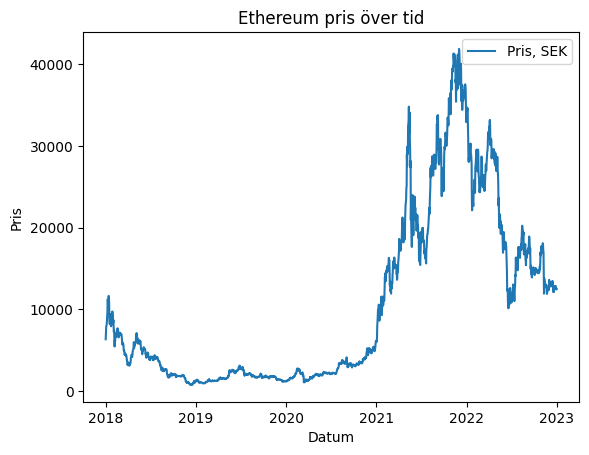

In [103]:
# Konvertera datumkolumnen till pandas datetime-objekt
data['Date'] = pd.to_datetime(data['Date'])
# Plotta datan
plt.plot(data['Date'], data['Price'], label='Pris, SEK')
plt.xlabel('Datum')
plt.ylabel('Pris')
plt.title('Ethereum pris över tid')

plt.legend()
plt.show()

In [106]:
# Ställer in kolumnen 'Date' som index
data = data.set_index('Date')

# Konverterar indexet till ett DateTimeIndex-objekt
data.index = pd.to_datetime(data.index,unit='ns')

# Skriv ut det nya indexet
print(data.index)

DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04',
               '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08',
               '2018-01-09', '2018-01-10',
               ...
               '2022-12-22', '2022-12-23', '2022-12-24', '2022-12-25',
               '2022-12-26', '2022-12-27', '2022-12-28', '2022-12-29',
               '2022-12-30', '2022-12-31'],
              dtype='datetime64[ns]', name='Date', length=1825, freq=None)


In [107]:
# Tilldelar strängen 'Price'(2:a kolumnen i datasettet) till variabeln aim
# aim variabeln kan sedan användas för att referera till kolumnen 'Price'

aim='Price'

In [108]:
# Jag delar upp mitt datasett i en träningssekvens och en testsekvens samt definierar en funktion 'line_plot' 
# för att rita en linjediagram. 

train_data = data.iloc[:1450]
test_data = data.iloc[1450:]

def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('ETHEREUM', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)
    ax.xaxis.set_major_locator(plt.MaxNLocator(8)) 

In [109]:
# Printar ut train_data för att se att det ser okey ut.
print(train_data)

            Price
Date             
2018-01-01   6345
2018-01-02   7155
2018-01-03   7879
2018-01-04   7959
2018-01-05   8199
...           ...
2021-12-17  35881
2021-12-18  35540
2021-12-19  36382
2021-12-20  35897
2021-12-21  36135

[1450 rows x 1 columns]


In [110]:
# Printar ut test_data för att se att det också ser okey ut.
print(test_data)

            Price
Date             
2021-12-22  36854
2021-12-23  36282
2021-12-24  37388
2021-12-25  37017
2021-12-26  37523
...           ...
2022-12-27  12867
2022-12-28  12698
2022-12-29  12438
2022-12-30  12567
2022-12-31  12503

[375 rows x 1 columns]


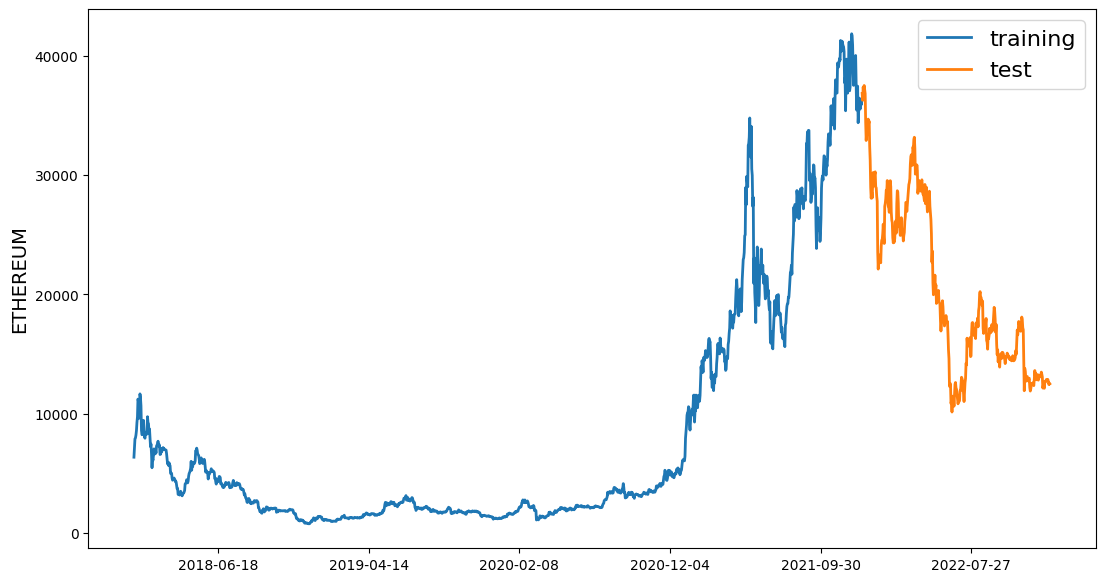

In [111]:
# Plottar ut en kurva över träningsdata och testdata med hjälp av funktionen 'line_plot'.
line_plot(train_data[aim], test_data[aim], 'training', 'test', title='')

### Normalisering av data. 
Normalisering är en vanlig förbehandlingsteknik inom maskininlärning för att skala data till ett gemensamt intervall eller en gemensam fördelning, vilket kan förbättra prestanda och konvergens för många algoritmer. 

In [112]:
# Denna funktion normaliserar data så att den första punkten blir noll och sedan beräknar avvikelserna 
# från denna baslinje. Detta innebär att den första datapunkten i varje serie blir 0 och alla andra punkter 
# representerar en relativ förändring från den första punkten.

# Varje värde i dataserien divideras med det första värdet i serien. Sedan dras -1 av. Detta leder till att det första värdet 
# blir 0 och alla andra värden representerar den relativa förändringen från det första värdet.
def normalise_zero_base(ethereum_series):
    return ethereum_series / ethereum_series.iloc[0] - 1


# Denna funktion normaliserar data till intervallet [0, 1] genom att skala varje värde baserat på det minsta och största värdet i datamängden.
def normalise_min_max(ethereum_series):
    return (ethereum_series - ethereum_series.min()) / (data.max() - ethereum_series.min())

In [113]:
#  Denna funktion extraherar fönster av data från en serie av Ethereum-priser, normaliserar varje fönster om det behövs, 
# och returnerar en uppsättning av dessa fönster som en numpy-array för användning i en LSTM-modell.
def extract_window_data(ethereum_series, window_len=5, zero_base=True):
    window_data = []
    for start_idx in range(len(ethereum_series) - window_len):
        window_prices = ethereum_series[start_idx: (start_idx + window_len)].copy()
        if zero_base:
            window_prices = normalise_zero_base(window_prices)
        window_data.append(window_prices.values)
    return np.array(window_data)


# Funktionen 'prepare_data' förbereder data för att träna och testa LSTM-modellen.
# Funktionen använder 'extract_window_data' för att extrahera fönster av data från tränings- och testdatamängderna (train_data och test_data). 
def prepare_data(aim, window_len=10, zero_base=True):
    train_window_data = extract_window_data(train_data, window_len, zero_base)
    test_window_data = extract_window_data(test_data, window_len, zero_base)
    train_target_values = train_data[aim][window_len:].values
    test_target_values = test_data[aim][window_len:].values
    if zero_base:
        train_target_values = train_target_values / train_data[aim][:-window_len].values - 1
        test_target_values = test_target_values / test_data[aim][:-window_len].values - 1

    return train_data, test_data, train_window_data, test_window_data, train_target_values, test_target_values

# en funktion som förbereder data för framtida användning i en maskininlärningsmodell.
# OBS!!!! OSÄKER PÅ OM JAG KOMMER INKLUDERA DENNA FUNKTION!!!
def prepare_future_data(aim, window_len=10, zero_base=True, future_data=None):
    if future_data is None:
        return None, None
    
    future_window_data = extract_window_data(future_data, window_len, zero_base)
    future_target_values = future_data[aim][window_len:].values
    if zero_base:
        future_target_values = future_target_values / future_data[aim][:-window_len].values - 1
    
    return future_window_data, future_target_values

In [114]:
# Nedan funktion bygger en LSTM-modell (Long Short-Term Memory) 
# och returnerar en kompilerad LSTM-modell.

def build_lstm_model(input_data, output_size, neurons, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout)) # Lägger till dropout-lager för att förhindra överanpassning genom att slumpmässigt stänga av ett visst antal noder under träning.
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model #Returnerar den kompilerade modellen för användning.
np.random.seed(245) # Samma sekvens av slumpmässiga tal att genereras varje gång koden körs, förutsatt att alla andra förhållanden förblir desamma.
window_len = 5
zero_base = True
lstm_neurons = 50 # Antalet neuroner i ett LSTM-lager är en hyperparameter som kan justeras för att påverka modellens kapacitet och inlärningsförmåga.
epochs = 20
batch_size = 32
loss = 'mse' # Förlustfunktionen Mean Squared Error (MSE), vilket är en vanlig förlustfunktion för regressionsproblem.
dropout = 0.24 # Dropout är en regleringsteknik som används för att förhindra överanpassning i neurala nätverk genom att slumpmässigt "stänga av" (sätta noll) ett visst antal noder under träningen.
optimizer = 'adam' # Adam (Adaptive Moment Estimation)
train_data, test_data, train_window_data, test_window_data, train_target_values, test_target_values = prepare_data(aim,window_len, zero_base)
     

print(train_window_data.shape), nedan, kommer visa de faktiska dimensionerna på  träningsdatan och ge en uppfattning om storleken på träningsdatan. Detta är användbart för att kontrollera att datan har rätt form och storlek innan den matas in i  modellen.

In [115]:
print(train_window_data.shape)

(1445, 5, 1)


### (1445, 5, 1) betyder följande:

Det finns totalt 1445 tidsfönster.
Varje tidsfönster har 5 tidssteg.
Varje tidssteg har 1 funktion (variabel).
Jag har 1445 exempel av tidssekvensdata för träning, där varje exempel består av en sekvens av 5 tidssteg, och varje tidssteg innehåller endast en variabel.

Detta är den form man förväntar sig att träningsdata ska ha för att matas in i en LSTM-modell. Varje tidsfönster representerar en sekvens av datapunkter över tid, och LSTM-modellen kommer att träna på dessa sekvenser för att göra förutsägelser.

In [116]:
# Bygger LSTM-modellen med de specificerade parametrarna
model = build_lstm_model(
    train_window_data, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)

# Tränar modellen med träningsdata och validerar den med testdata
modelfit = model.fit(
    train_window_data, train_target_values, validation_data=(test_window_data, test_target_values), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)
     

Epoch 1/20


/mnt/c/Users/aras/python_iths/iths_2023_sep_dec/aras_venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0105 - val_loss: 0.0048
Epoch 2/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0055 - val_loss: 0.0033
Epoch 3/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0046 - val_loss: 0.0030
Epoch 4/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0047 - val_loss: 0.0029
Epoch 5/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0040 - val_loss: 0.0024
Epoch 6/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0037 - val_loss: 0.0023
Epoch 7/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0033 - val_loss: 0.0021
Epoch 8/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0034 - val_loss: 0.0021
Epoch 9/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0032 - val_loss: 0.0019
Epoch 10/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0031 - val_loss: 0.0018
Epoch 11/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0033 - val_loss: 0.0020
Epoch 12/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0031 - val_loss: 0.0018

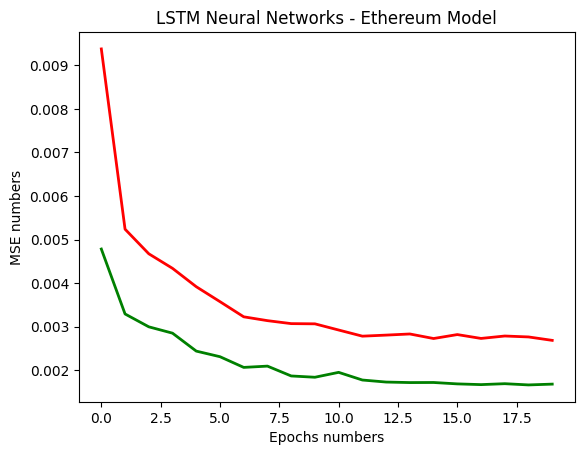

In [117]:
plt.plot(modelfit.history['loss'],'r',linewidth=2, label='Training loss')
plt.plot(modelfit.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('LSTM Neural Networks - Ethereum Model')
plt.xlabel('Epochs numbers')
plt.ylabel('MSE numbers')
plt.show()

In [118]:
# Importera modulen för att spara modellen
from tensorflow.keras.models import save_model

# Ange sökvägen för att spara modellen och filnamnet
model_path = "my_model.keras"

# Spara modellen som en keras-fil
save_model(model, model_path)

print("Modellen har sparats som en Keras-fil på sökvägen:", model_path)



Modellen har sparats som en Keras-fil på sökvägen: my_model.keras


Medelabsolutfelet (MAE) mellan modellens förutsägelser och de verkliga målen. Detta är ett vanligt sätt att utvärdera en regressionsmodells prestanda.

In [119]:
#Skapa en serie 'targets' som innehåller de verkliga målen från testdatan 'test_data'
targets = test_data[aim][window_len:]
#Använder den tränade modellen för att göra förutsägelser på testdatan test_window_data. "squeeze" (flattar) ut resultaten till en endimensionell array.
preds = model.predict(test_window_data).squeeze()
preds = pd.Series(index=targets.index, data=preds)
#Beräknar medelvärdet av absolutvärdet av skillnaden mellan förutsägelserna preds och de verkliga målen test_target_values. Detta ger MAE mellan modellens förutsägelser och de verkliga målen på testdatan.
mean_absolute_error(preds, test_target_values)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


0.030404016343471407

Medelkvadratfelet (MSE=mean squared error) mellan modellens förutsägelser och de verkliga målen på testdatan. MSE är en annan vanlig måttstock för att utvärdera prestanda hos en regressionsmodell, och det mäter genomsnittet av kvadraten på skillnaden mellan varje förutsagt värde och det faktiska värdet.

Det är en bra praxis att använda både MSE och MAE för att utvärdera prestanda hos en regressionsmodell, eftersom de båda ger olika aspekter av modellens fel. MSE ger mer vikt åt stora fel på grund av kvadreringen, medan MAE ger en bättre uppfattning om genomsnittlig absolut felstorlek.

In [120]:
#Beräknar medelvärdet av kvadraten av skillnaden mellan varje element i preds (modellens förutsägelser) och motsvarande element i 
# test_target_values (de verkliga målen på testdatan). Detta ger dig MSE mellan modellens förutsägelser och de verkliga målen.
from sklearn.metrics import mean_squared_error
SCORE_MSE=mean_squared_error(preds, test_target_values)
SCORE_MSE

0.001726329423452928

R2-score, förklaringsgraden, är ett användbart verktyg för att bedöma modellens prestanda. R2-score är ett mått på hur väl den beroende variabeln förklaras av den oberoende variabeln i modellen. Det ger en indikation på hur bra modellen passar dina data jämfört med en enkel genomsnittsmodell.

In [121]:
from sklearn.metrics import r2_score
r2_score=r2_score(test_target_values, preds)
r2_score*100

81.29248818314444

Date
2021-12-27    37617.272385
2021-12-28    37321.070058
2021-12-29    36984.635093
2021-12-30    34765.410446
2021-12-31    32992.562576
                  ...     
2022-12-27    12885.285503
2022-12-28    12904.605603
2022-12-29    12757.944056
2022-12-30    12494.198456
2022-12-31    12570.442745
Length: 370, dtype: float64
Date
2021-12-27    37617.272385
2021-12-28    37321.070058
2021-12-29    36984.635093
2021-12-30    34765.410446
2021-12-31    32992.562576
                  ...     
2022-12-27    12885.285503
2022-12-28    12904.605603
2022-12-29    12757.944056
2022-12-30    12494.198456
2022-12-31    12570.442745
Length: 370, dtype: float64


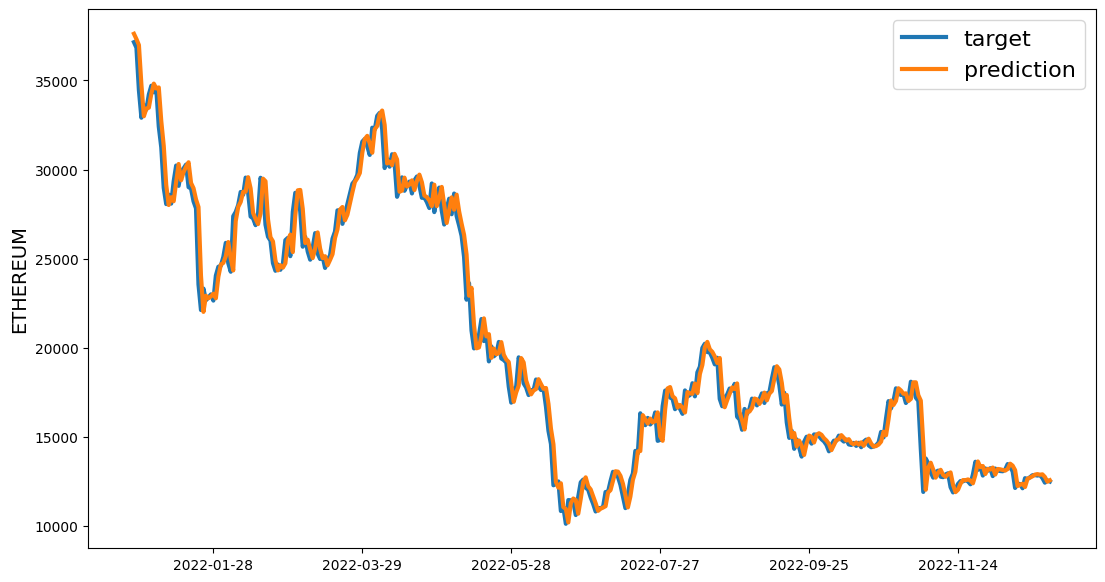

In [122]:
preds = test_data[aim].values[:-window_len] * (preds + 1)
print(preds)  
preds = pd.Series(index=targets.index, data=preds)
print(preds)
line_plot(targets, preds, 'target', 'prediction', lw=3)

In [123]:
print(targets.index[-1])

2022-12-31 00:00:00


In [124]:
print(preds.index[-1])

2022-12-31 00:00:00


In [125]:
from datetime import datetime

# Skapa ett datetime-objekt för det specifika datumet
specifikt_datum = datetime(2022, 1, 1).date()

# Omvandla specifikt_datum till ett strängformat som matchar indexformatet i preds
specifikt_datum_str = specifikt_datum.strftime('%Y-%m-%d')

# Komma åt värdet för det specifika datumet i preds
pred_värde_för_specifikt_datum = preds.loc[specifikt_datum_str]
print(f"Värdet för det prediktade datumet, {specifikt_datum_str} är:", int(pred_värde_för_specifikt_datum))

# Komma åt värdet för det specifika datumet i targets
target_värde_för_specifikt_datum = targets.loc[specifikt_datum_str]
print(f"Värdet för target datumet,{specifikt_datum_str} är:", target_värde_för_specifikt_datum)




Värdet för det prediktade datumet, 2022-01-01 är: 33424
Värdet för target datumet,2022-01-01 är: 33362


In [28]:
antal_dagar = 1
# Lägg till antal dagar till det sista datumet
future_date = targets.index[-1] + pd.Timedelta(days=antal_dagar)
print(future_date)

# Skapa ett datetime-objekt för det specifika datumet
#specifikt_datum = datetime(2022, 1, 1).date()

# Förbered datointervalldata för modellen
#future_data = pd.DataFrame(index=[future_date])
#print(future_data)

# Skapa DataFrame med det framtida datumet som index och kolumnerna "Date" och "Price"
future_data = pd.DataFrame(data={"Date": [future_date], "Price": [0]}, columns=["Date", "Price"])

# Konvertera datatypen för kolumnen "Price" till float
future_data['Price'] = future_data['Price'].astype(float)

# Omvandla specifikt_datum till ett strängformat som matchar indexformatet i preds
#future_date_str = future_date.strftime('%Y-%m-%d')
#print(future_date_str)


# Gör en förutsägelse för det framtida datumet
future_prediction = model.predict(future_data)

print("Framtida förutsägelse för priset:", future_prediction)

2023-01-01 00:00:00


ValueError: Invalid dtype: datetime64[ns]

In [29]:
print(future_date)

2023-01-01 00:00:00


In [30]:
print(future_prediction)

NameError: name 'future_prediction' is not defined

In [133]:
import pandas as pd

# Antal dagar att lägga till
antal_dagar = 5

# Omvandla `targets` till ett pandas datetime-index om det inte redan är det
targets = pd.to_datetime(targets)

# Beräkna det framtida datumet
future_date = targets.index[-1] + pd.Timedelta(days=antal_dagar)

# Gör en förutsägelse för det framtida datumet
future_prediction = model.predict(future_date)

print("Framtida förutsägelse för priset:", future_prediction)





ValueError: Unrecognized data type: x=2022-11-13 00:00:00 (of type <class 'pandas._libs.tslibs.timestamps.Timestamp'>)

In [ ]:
print(future_date)

2022-11-13 00:00:00


In [125]:
future_prediction = model.predict(test_window_data[-1:])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


In [126]:
print(test_window_data)

[[[ 0.        ]
  [-0.0155207 ]
  [ 0.01448961]
  [ 0.00442286]
  [ 0.01815271]]

 [[ 0.        ]
  [ 0.03048344]
  [ 0.02025798]
  [ 0.03420429]
  [ 0.02384102]]

 [[ 0.        ]
  [-0.00992297]
  [ 0.00361078]
  [-0.00644592]
  [-0.0147106 ]]

 ...

 [[ 0.        ]
  [ 0.00345682]
  [-0.02592614]
  [-0.01261739]
  [ 0.04274932]]

 [[ 0.        ]
  [-0.02928174]
  [-0.01601883]
  [ 0.03915715]
  [ 0.02819085]]

 [[ 0.        ]
  [ 0.01366298]
  [ 0.07050334]
  [ 0.05920625]
  [ 0.01780328]]]


In [127]:
print(test_window_data[-1])

[[0.        ]
 [0.01366298]
 [0.07050334]
 [0.05920625]
 [0.01780328]]


In [128]:
print(future_prediction)

[[0.02532659]]


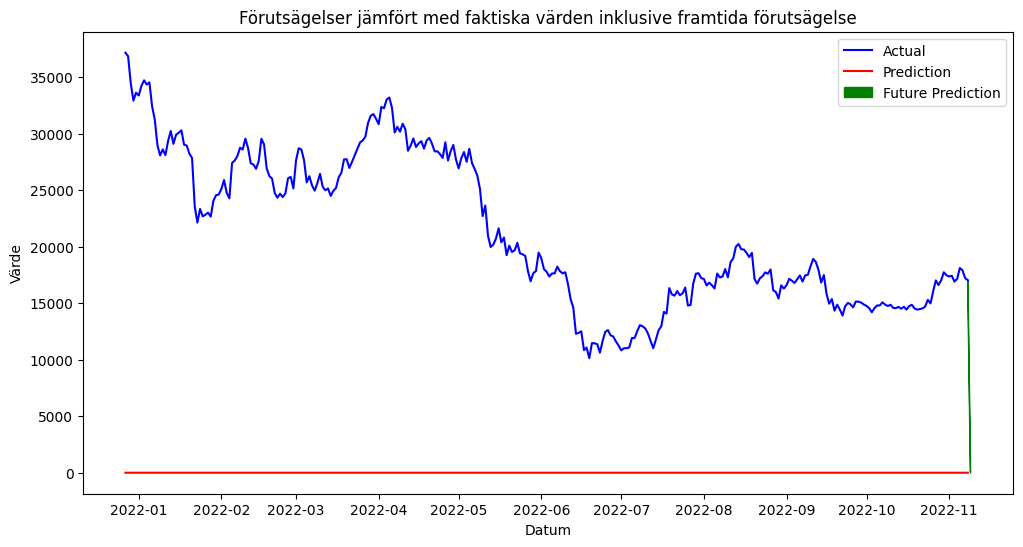

In [129]:
import pandas as pd
import matplotlib.pyplot as plt


# Skapa en pandas Series för framtida förutsägelse
future_prediction_series = pd.Series(index=[future_date], data=future_prediction.flatten())

# Plot förutsägelser och målvariabler
plt.figure(figsize=(12, 6))
plt.plot(targets.index, targets, label='Actual', color='blue')  # faktiska värden
plt.plot(preds.index, preds, label='Prediction', color='red')  # förutsägelser

# Plotta också future_prediction
#plt.plot(future_prediction_series.index, future_prediction_series, 'ro', label='Future Prediction')  # framtida förutsägelse

# Plotta en pil för att visa den framtida förutsägelsen
plt.arrow(targets.index[-1], targets.iloc[-1], 1, future_prediction_series.values[0] - targets.iloc[-1], 
width=0.1, head_width=0.3, head_length=0.2, color='green', label='Future Prediction')

# Ställ in etiketter och titel
plt.xlabel('Datum')
plt.ylabel('Värde')
plt.title('Förutsägelser jämfört med faktiska värden inklusive framtida förutsägelse')
plt.legend()

# Visa plotten
plt.show()







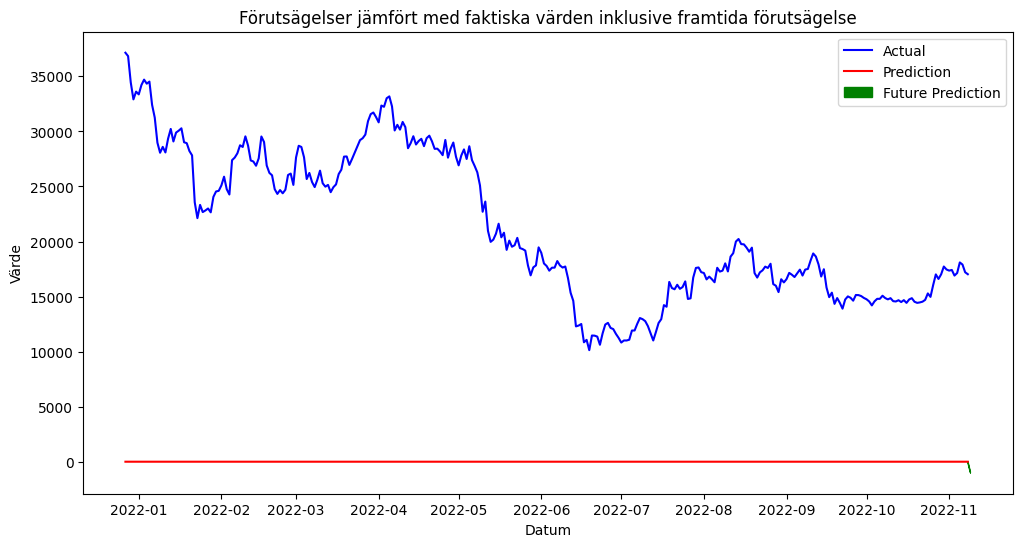

In [123]:
import pandas as pd
import matplotlib.pyplot as plt

# Lägg till en dag till det sista datumet
future_date = targets.index[-1] + pd.Timedelta(days=1)

# Skapa en pandas Series för framtida förutsägelse
future_prediction_series = pd.Series(index=[future_date], data=future_prediction.flatten())

# Plot förutsägelser och målvariabler
plt.figure(figsize=(12, 6))
plt.plot(targets.index, targets, label='Actual', color='blue')  # faktiska värden
plt.plot(preds.index, preds, label='Prediction', color='red')  # förutsägelser

# Bestäm startpositionen för pilen (där förutsägelsen slutar)
start_x = preds.index[-1]
start_y = preds.iloc[-1]

# Bestäm slutpositionen för pilen (en viss längd ner på y-axeln från startpositionen)
end_x = start_x + pd.Timedelta(days=1)
#end_y = start_y + pd.Timedelta(days=1)
end_y = start_y - 1000.0  # Justera detta värde för att ändra längden på pilen

# Plotta pilen för att visa den framtida förutsägelsen
plt.arrow(start_x, start_y, 1, end_y - start_y, 
          width=0.1, head_width=0.3, head_length=0.2, color='green', label='Future Prediction')

# Ställ in etiketter och titel
plt.xlabel('Datum')
plt.ylabel('Värde')
plt.title('Förutsägelser jämfört med faktiska värden inklusive framtida förutsägelse')
plt.legend()

# Visa plotten
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


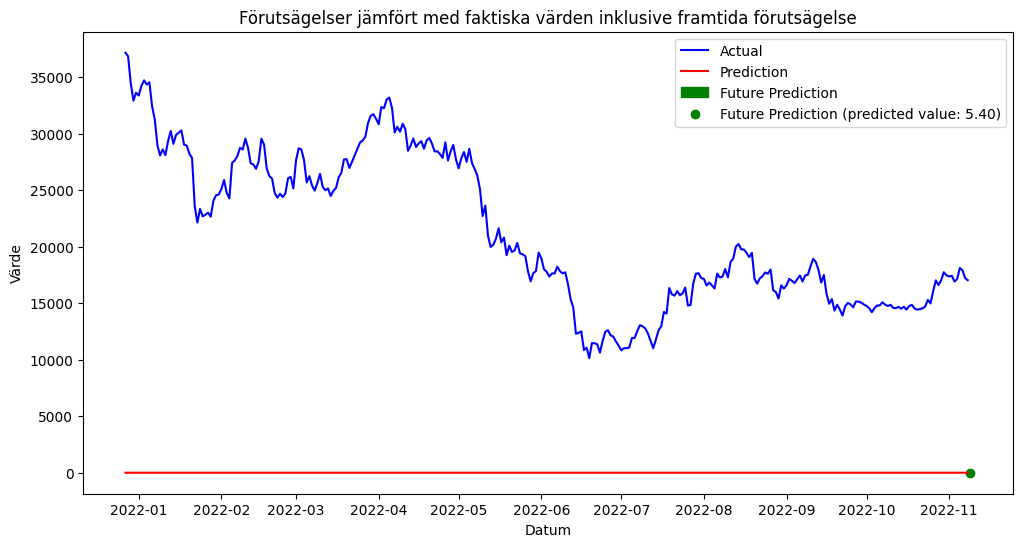

In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Lägg till en dag till det sista datumet för att få det framtida datumet
future_date = targets.index[-1] + pd.Timedelta(days=1)

# Omvandla tidstämpeln till ett numeriskt värde (t.ex. Unix-timestamp)
future_date_numeric = future_date.timestamp()

# Använd modellen för att göra en förutsägelse för det framtida y-värdet
future_prediction = model.predict(np.array([[future_date_numeric]]).reshape(1, 1, 1))

# Plot förutsägelser och målvariabler
plt.figure(figsize=(12, 6))
plt.plot(targets.index, targets, label='Actual', color='blue')  # faktiska värden
plt.plot(preds.index, preds, label='Prediction', color='red')  # förutsägelser

# Plotta en pil för att visa den framtida förutsägelsen
plt.arrow(future_date, preds[-1], 0, future_prediction[0][0] - preds[-1], 
          width=0.1, head_width=0.3, head_length=0.2, color='green', label='Future Prediction')

# Skriv ut den förutsagda framtida punkten
plt.scatter(future_date, future_prediction[0][0], color='green', label=f'Future Prediction (predicted value: {future_prediction[0][0]:.2f})')

# Ställ in etiketter och titel
plt.xlabel('Datum')
plt.ylabel('Värde')
plt.title('Förutsägelser jämfört med faktiska värden inklusive framtida förutsägelse')
plt.legend()

# Visa plotten
plt.show()











In [214]:
import pandas as pd
import numpy as np

def get_predicted_x_for_date(model, input_date, test_data, aim, window_len):
    # Omvandla datumet till det format som modellen förväntar sig
    input_timestamp = pd.Timestamp(input_date)
    input_numeric = input_timestamp.timestamp()
    
    # Förutsäg x-värdet för det angivna datumet med modellen
    input_data = np.array([[input_numeric]]).reshape(1, 1, 1)
    predicted_y = model.predict(input_data)
    
    # Beräkna det förutsagda x-värdet baserat på det förutsagda y-värdet
    predicted_x = (test_data[aim].values[-window_len] * (predicted_y + 1)).squeeze()
    
    return predicted_x

# Användning av funktionen
input_date = '2020-04-10'
predicted_x_value = get_predicted_x_for_date(model, input_date, test_data, aim, window_len)
print("Förutsagt x-värde för datumet", input_date, "är:", predicted_x_value)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Förutsagt x-värde för datumet 2020-04-10 är: 95389.26


För att extrapolera framtida data baserat på historiska data kan du använda olika metoder, beroende på den specifika typen av data och de mönster som finns i den. Här är ett enkelt exempel på hur du kan extrapolera framtida Ethereum-priser baserat på historiska priser:

Först definierar vi en funktion som kan användas för att extrapolera framtida priser baserat på historiska priser och eventuella trender eller mönster:

In [3]:
import pandas as pd

def load_future_eth_prices(csv_file):
    # Läs in data från CSV-filen
    future_data = pd.read_csv(csv_file)
    
    # Konvertera kolumnen "Date" till datatypen datetime
    future_data['Date'] = pd.to_datetime(future_data['Date'])
    
    return future_data

# Använd funktionen för att ladda in framtida Ethereum-priser från CSV-filen
future_eth_prices = load_future_eth_prices("framtidsdata_ethereum_prices.csv")

# Visa de första raderna i DataFrame
print(future_eth_prices.head())


        Date  Price
0 2022-11-09  14343
1 2022-11-10  11918
2 2022-11-11  13794
3 2022-11-12  13518
4 2022-11-13  13020


In [16]:
import numpy as np
from scipy.optimize import curve_fit

def extrapolate_future_prices(prices, future_dates):
    # Extrahera tidsserien och priserna från historiska data
    time_series = np.arange(len(prices))
    
    # Skapa en funktion för att passa in de historiska priserna och extrapolera framtida priser
    def price_function(t, a, b, c):
        return a * np.exp(b * t) + c  # Exempel: exponentiell tillväxtmodell
    
    # Anpassa kurvan till de historiska priserna för att extrapolera framtida priser
    popt, _ = curve_fit(price_function, time_series, prices)
    
    # Extrapolera priser för framtida datum
    future_prices = price_function(future_dates, *popt)
    
    return future_prices


In [17]:
import numpy as np
from scipy.optimize import curve_fit

def extrapolate_future_prices(prices, future_dates):
    # Extrahera tidsserien och priserna från historiska data
    time_series = np.arange(len(prices))
    
    # Skapa en funktion för att passa in de historiska priserna och extrapolera framtida priser
    def price_function(t, a, b, c):
        return a * np.exp(b * t) + c  # Exempel: exponentiell tillväxtmodell
    
    # Anpassa kurvan till de historiska priserna för att extrapolera framtida priser
    popt, _ = curve_fit(price_function, time_series, prices)
    
    return popt


In [18]:
import numpy as np

def extrapolate_future_prices(prices, future_dates, popt):
    # Extrahera tidsserien från historiska data
    time_series = np.arange(len(prices))
    
    # Skapa en funktion för att beräkna framtida priser baserat på de optimala parametrarna
    def price_function(t):
        a, b, c = popt
        return a * np.exp(b * t) + c  # Exempel: exponentiell tillväxtmodell
    
    # Beräkna framtida priser för de angivna datum
    future_prices = price_function(len(prices) + future_dates)
    
    return future_prices


In [19]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit

def load_future_eth_prices(csv_file):
    # Läs in data från CSV-filen
    future_data = pd.read_csv(csv_file)
    
    # Konvertera kolumnen "Date" till datatypen datetime
    future_data['Date'] = pd.to_datetime(future_data['Date'])
    
    return future_data

def extrapolate_future_prices(prices, future_dates):
    # Extrahera tidsserien och priserna från historiska data
    time_series = np.arange(len(prices))
    
    # Skapa en funktion för att passa in de historiska priserna och extrapolera framtida priser
    def price_function(t, a, b, c):
        return a * np.exp(b * t) + c  # Exempel: exponentiell tillväxtmodell
    
    # Anpassa kurvan till de historiska priserna för att extrapolera framtida priser
    popt, _ = curve_fit(price_function, time_series, prices)
    
    # Extrapolera priser för framtida datum
    future_prices = price_function(len(prices) + future_dates, *popt)
    
    return future_prices

def historical_and_future_eth_prices(csv_file, future_dates):
    # Ladda in historiska och framtida Ethereum-priser från CSV-filen
    historical_eth_prices = pd.read_csv(csv_file)
    future_eth_prices = load_future_eth_prices("framtidsdata_ethereum_prices.csv")
    
    # Extrapolera framtida priser baserat på historiska Ethereum-priser
    future_prices = extrapolate_future_prices(historical_eth_prices['Price'], future_dates)
    
    return future_prices


In [14]:
from datetime import datetime, timedelta
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd

def load_future_eth_prices(csv_file):
    # Läs in CSV-filen och returnera den som en pandas DataFrame
    return pd.read_csv(csv_file)

def extrapolate_future_prices(prices, future_dates):
    # Konvertera tidpunkterna (datetime-objekten) till heltalsvärden som representerar antalet dagar sedan startdatumet
    start_date = prices.index[0]
    prices.index = pd.to_datetime(prices.index)  # Konvertera indexet till datetime-objekt
    time_series = [(date - start_date) / timedelta(days=1) for date in prices.index]  # Använd timedelta för att beräkna antalet dagar

    def price_function(t, a, b, c):
        return a * np.exp(b * t) + c  # Exempel: exponentiell tillväxtmodell

    # Anpassa kurvan till de historiska priserna för att extrapolera framtida priser
    popt, _ = curve_fit(price_function, time_series, prices.values.ravel())

    # Konvertera framtida datum till datetime-objekt
    future_dates = pd.to_datetime(future_dates)

    # Beräkna tidsserien för framtida datum
    future_time_series = [(date - start_date) / timedelta(days=1) for date in future_dates]

    # Extrapolera priser för framtida datum
    future_prices = price_function(future_time_series, *popt)

    return future_prices

# Ange det framtida datumet som du vill extrapolera priser för
future_date = datetime(2024, 4, 15)

# Skapa en lista med framtida datum baserat på det angivna datumet
future_dates = [(future_date + timedelta(days=i)) for i in range(30)]  # Exempel: extrapolera priser för 30 dagar framåt

# Ladda in framtida Ethereum-priser från CSV-filen
future_eth_prices = load_future_eth_prices("framtidsdata_ethereum_prices.csv")

# Extrapolera framtida priser baserat på historiska Ethereum-priser
future_prices = extrapolate_future_prices(future_eth_prices, future_dates)

print("Framtida extrapolerade priser:", future_prices)








TypeError: Addition/subtraction of integers and integer-arrays with Timestamp is no longer supported.  Instead of adding/subtracting `n`, use `n * obj.freq`

#### GÖR OM GÖR RÄTT

In [51]:
from tensorflow.keras.models import load_model

# Läs in den tränade modellen från filen
trained_model = load_model("my_model.keras")



/mnt/c/Users/aras/python_iths/iths_2023_sep_dec/aras_venv/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [55]:
import pandas as pd

# Läs in filen och skapa en DataFrame
future_data = pd.read_csv("framtidsdata_ethereum_prices.csv")

# Visa de första raderna i DataFrame
print(future_data.head())

# Ställer in kolumnen 'Date' som index
future_data = future_data.set_index('Date')

# Skriv ut det nya indexet
print(future_data.index)

# Visa de första raderna i DataFrame för att kontrollera att allt ser bra ut
print(future_data.head())


         Date  Price
0  2022-11-09  14343
1  2022-11-10  11918
2  2022-11-11  13794
3  2022-11-12  13518
4  2022-11-13  13020
Index(['2022-11-09', '2022-11-10', '2022-11-11', '2022-11-12', '2022-11-13',
       '2022-11-14', '2022-11-15', '2022-11-16', '2022-11-17', '2022-11-18',
       '2022-11-19', '2022-11-20', '2022-11-21', '2022-11-22', '2022-11-23',
       '2022-11-24', '2022-11-25', '2022-11-26', '2022-11-27', '2022-11-28',
       '2022-11-29', '2022-11-30', '2022-12-01', '2022-12-02', '2022-12-03',
       '2022-12-04', '2022-12-05', '2022-12-06', '2022-12-07', '2022-12-08',
       '2022-12-09', '2022-12-10', '2022-12-11', '2022-12-12', '2022-12-13',
       '2022-12-14', '2022-12-15', '2022-12-16', '2022-12-17', '2022-12-18',
       '2022-12-19', '2022-12-20', '2022-12-21', '2022-12-22', '2022-12-23',
       '2022-12-24', '2022-12-25', '2022-12-26', '2022-12-27', '2022-12-28',
       '2022-12-29', '2022-12-30', '2022-12-31'],
      dtype='object', name='Date')
            Price
D

In [69]:
# Importera funktionen för att göra prognoser
from tensorflow.keras.models import load_model

# Läs in den tränade modellen från filen
trained_model = load_model("my_model.keras")

# Gör prognoser för framtida priser med den tränade modellen
future_prices = trained_model.predict(future_data).squeeze()

# Visa de första prognoserna
print(future_prices)


/mnt/c/Users/aras/python_iths/iths_2023_sep_dec/aras_venv/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 340ms/step
[5.396944  5.396565  5.39689   5.3968577 5.3967876 5.3967376 5.3967905
 5.396802  5.3967466 5.3967423 5.3967686 5.396779  5.3966293 5.3965583
 5.396604  5.396669  5.3967013 5.3966985 5.396712  5.396698  5.396665
 5.3967686 5.396869  5.3968086 5.396837  5.3967576 5.3968205 5.3968015
 5.3968215 5.3967524 5.396819  5.396803  5.3967986 5.3967967 5.3968105
 5.396853  5.39683   5.396796  5.396619  5.3966727 5.3966675 5.396615
 5.396732  5.3967233 5.396742  5.3967614 5.3967624 5.3967576 5.396763
 5.3967338 5.3966837 5.396709  5.3966966]
